# Esfandiar Kiani - DL - Midterm Question Implementation

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pickle

## Hyperparameters

In [2]:
input_size_ae = 1
hidden_size_ae = 16
decoder_hidden = 16
output_dim_ae = 1

sigma_init = 1.0
learning_rate_ae = 0.0001
epochs_ae = 200

# ----------------------------

mlp_input_dim = hidden_size_ae
mlp_hidden_dims = [32, 16]
mlp_output_dim = 1

learning_rate_mlp = 0.01
epochs_mlp = 250

# ----------------------------

time_steps = 10
train_ratio = 0.8
seed = 13
save_best_model_weights = True
full_model_file = f"best_model_weights.pkl"

## Functions

### Activation Functions 

In [3]:
def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def pureline(x):
    return x

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

In [4]:
def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def pureline_derivative(x):
    return np.ones_like(x)

# def sigmoid_derivative(x):
#     s = sigmoid(x)
#     return s * (1 - s)

def sigmoid_derivative(output):
    return output * (1 - output)

def tanh_derivative(x):
    return 1 - tanh(x)**2

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

In [5]:
def choose_function(x, name):
    if name == "relu":
        return relu(x)
    elif name == "tanh":
        return tanh(x)
    elif name == "sigmoid":
        return sigmoid(x)
    elif name == "leaky_relu":
        return leaky_relu(x)
    elif name == "pureline":
        return pureline(x)
    else:
        raise ValueError("Unknown activation")

In [6]:
def choose_function_derivate(x, name):
    if name == "relu":
        return relu_derivative(x)
    elif name == "tanh":
        return tanh_derivative(x)
    elif name == "sigmoid":
        return sigmoid_derivative(x)
    elif name == "leaky_relu":
        return leaky_relu_derivative(x)
    elif name == "pureline":
        return pureline_derivative(x)
    else:
        raise ValueError("Unknown activation")

### RBF Kernel 

In [7]:
def rbf_kernel(x, center, sigma=1.0):
    net = np.linalg.norm(x - center)
    return np.exp(-net**2 / (2 * sigma**2))

In [8]:
def rbf_kernel_derivative(x, center, sigma=1.0):
    diff = x - center
    rbf_val = rbf_kernel(x, center, sigma)
    return -diff / (sigma**2) * rbf_val

### Data Utility 

In [9]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [10]:
def denormalize_data(normalized_data, min_val, max_val):
    return normalized_data * (max_val - min_val) + min_val

In [11]:
def create_time_series(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

## Model

### RBF-Gated LSTM Cell

In [32]:
class LSTMCellRBF:
    def __init__(self, input_size, hidden_size, sigma_init=sigma_init, init_centers=None):
        self.input_size_ae = input_size
        self.hidden_size_ae = hidden_size
        self.total_input = input_size + hidden_size

        # Candidate cell weights
        self.Wc = np.random.randn(hidden_size, self.total_input) * 0.1
        self.bc = np.zeros(hidden_size)

        # RBF gate weights
        self.Wf = np.random.randn(hidden_size, self.total_input) * 0.1
        self.Wi = np.random.randn(hidden_size, self.total_input) * 0.1
        self.Wo = np.random.randn(hidden_size, self.total_input) * 0.1

        self.bf = np.zeros(hidden_size)
        self.bi = np.zeros(hidden_size)
        self.bo = np.zeros(hidden_size)

        self.sigma_init = sigma_init

        # Learnable centers
        if init_centers is None:
            self.cf = np.random.randn(hidden_size, self.total_input) * 0.1
            self.ci = np.random.randn(hidden_size, self.total_input) * 0.1
            self.co = np.random.randn(hidden_size, self.total_input) * 0.1
        else:
            self.cf = init_centers.copy()
            self.ci = init_centers.copy()
            self.co = init_centers.copy()

        # log(σ) for numerical stability
        self.log_sf = np.log(np.ones(hidden_size) * self.sigma_init)
        self.log_si = np.log(np.ones(hidden_size) * self.sigma_init)
        self.log_so = np.log(np.ones(hidden_size) * self.sigma_init)

    def rbf_gate(self, x, W, b, c, log_sigma):
        sigma = np.exp(log_sigma)
        sigma = np.clip(sigma, 1e-2, 10.0)
        pre = np.dot(W, x) + b
        diff = pre - np.sum(c * x, axis=1)
        # diff = np.linalg.norm(x - c_row)
        diff = np.clip(diff, -1e3, 1e3)
        diff_squared = np.clip(diff**2, 0, 1e6)
        exponent = -diff_squared / (2 * sigma**2 + 1e-6)
        exponent = np.clip(exponent, -50, 50)
        out = np.exp(exponent)
        return out, diff, sigma

    def forward(self, x_seq):
        self.x_seq = x_seq
        self.h_list, self.c_list, self.combined_list = [], [], []
        self.f_list, self.i_list, self.o_list = [], [], []
        self.f_diff, self.i_diff, self.o_diff = [], [], []
        self.sf_list, self.si_list, self.so_list = [], [], []
        self.c_hat_list = []

        h = np.zeros(self.hidden_size_ae)
        c = np.zeros(self.hidden_size_ae)

        for t in range(x_seq.shape[0]):
            xt = x_seq[t].flatten()
            combined = np.concatenate([h, xt])

            f, df, sf = self.rbf_gate(combined, self.Wf, self.bf, self.cf, self.log_sf)
            i, di, si = self.rbf_gate(combined, self.Wi, self.bi, self.ci, self.log_si)
            o, do, so = self.rbf_gate(combined, self.Wo, self.bo, self.co, self.log_so)

            pre_c = np.dot(self.Wc, combined) + self.bc
            c_hat = np.tanh(pre_c)
            c = f * c + i * c_hat
            h = o * np.tanh(c)

            self.h_list.append(h.copy())
            self.c_list.append(c.copy())
            self.combined_list.append(combined)

            self.f_list.append(f)
            self.i_list.append(i)
            self.o_list.append(o)
            self.f_diff.append(df)
            self.i_diff.append(di)
            self.o_diff.append(do)
            self.sf_list.append(sf)
            self.si_list.append(si)
            self.so_list.append(so)
            self.c_hat_list.append(c_hat)

        return h

    def backward(self, dL_dh_last, learning_rate_ae):
        dh_next = dL_dh_last
        dc_next = np.zeros(self.hidden_size_ae)

        dWf = np.zeros_like(self.Wf)
        dWi = np.zeros_like(self.Wi)
        dWo = np.zeros_like(self.Wo)
        dWc = np.zeros_like(self.Wc)

        dbf = np.zeros_like(self.bf)
        dbi = np.zeros_like(self.bi)
        dbo = np.zeros_like(self.bo)
        dbc = np.zeros_like(self.bc)

        dcf = np.zeros_like(self.cf)
        dci = np.zeros_like(self.ci)
        dco = np.zeros_like(self.co)

        dlog_sf = np.zeros_like(self.log_sf)
        dlog_si = np.zeros_like(self.log_si)
        dlog_so = np.zeros_like(self.log_so)

        for t in reversed(range(len(self.x_seq))):
            h = self.h_list[t]
            c = self.c_list[t]
            combined = self.combined_list[t]

            f = self.f_list[t]
            i = self.i_list[t]
            o = self.o_list[t]
            df = self.f_diff[t]
            di = self.i_diff[t]
            do = self.o_diff[t]
            sf = self.sf_list[t]
            si = self.si_list[t]
            so = self.so_list[t]
            c_hat = self.c_hat_list[t]

            c_prev = self.c_list[t - 1] if t > 0 else np.zeros_like(c)
            tanh_c = np.tanh(c)

            safe_sf2 = sf**2 + 1e-6
            safe_si2 = si**2 + 1e-6
            safe_so2 = so**2 + 1e-6

            d_o = dh_next * tanh_c
            d_c = dh_next * o * (1 - tanh_c**2) + dc_next
            d_f = d_c * c_prev
            d_i = d_c * c_hat
            d_c_hat = d_c * i * (1 - c_hat**2)

            dWf += np.outer(d_f * df / safe_sf2, combined)
            dWi += np.outer(d_i * di / safe_si2, combined)
            dWo += np.outer(d_o * do / safe_so2, combined)
            dWc += np.outer(d_c_hat, combined)

            dbf += d_f * df / safe_sf2
            dbi += d_i * di / safe_si2
            dbo += d_o * do / safe_so2
            dbc += d_c_hat

            dcf += (d_f * f * df / safe_sf2)[:, None] * combined
            dci += (d_i * i * di / safe_si2)[:, None] * combined
            dco += (d_o * o * do / safe_so2)[:, None] * combined

            dlog_sf += (df**2 / safe_sf2) * d_f * f
            dlog_si += (di**2 / safe_si2) * d_i * i
            dlog_so += (do**2 / safe_so2) * d_o * o

            d_combined = (
                np.dot(self.Wf.T, d_f * df / safe_sf2) +
                np.dot(self.Wi.T, d_i * di / safe_si2) +
                np.dot(self.Wo.T, d_o * do / safe_so2) +
                np.dot(self.Wc.T, d_c_hat)
            )

            dh_next = d_combined[:self.hidden_size_ae]
            dc_next = d_c * f

        for name, param, grad in zip(
            ['Wf','Wi','Wo','Wc','bf','bi','bo','bc','cf','ci','co','log_sf','log_si','log_so'],
            [self.Wf,self.Wi,self.Wo,self.Wc,self.bf,self.bi,self.bo,self.bc,
             self.cf,self.ci,self.co,self.log_sf,self.log_si,self.log_so],
            [dWf,dWi,dWo,dWc,dbf,dbi,dbo,dbc,dcf,dci,dco,dlog_sf,dlog_si,dlog_so]):
            param -= learning_rate_ae * grad

        self.log_sf = np.clip(self.log_sf, -2, 2)
        self.log_si = np.clip(self.log_si, -2, 2)
        self.log_so = np.clip(self.log_so, -2, 2)


### AutoEncoder 

In [13]:
class AutoEncoder:
    def __init__(self, encoder: LSTMCellRBF, hidden_dim: int, output_dim_ae: int):
        self.encoder = encoder
        self.hidden_dim = hidden_dim
        self.output_dim_ae = output_dim_ae

        # Decoder weights (linear layer)
        self.W_dec = np.random.randn(hidden_dim, output_dim_ae)
        self.b_dec = np.zeros(output_dim_ae)

        self.best_encoder_weights = None

    def forward(self, x_seq):
        encoded = self.encoder.forward(x_seq)
        net = np.dot(encoded, self.W_dec) + self.b_dec
        net = np.clip(net, -50, 50)
        
        reconstructed = sigmoid(net)
        # reconstructed = np.clip(reconstructed, 1e-7, 1 - 1e-7)
        
        self.last_encoded = encoded
        self.last_output = reconstructed
        return reconstructed, encoded
        
    def backward(self, x_seq, target, learning_rate_ae):
        # Forward pass again to get intermediate values
        reconstructed, encoded = self.forward(x_seq)

        # Loss = MSE
        error = reconstructed - target
        loss = np.mean(error ** 2)

        # Derivative of MSE loss w.r.t output
        d_loss = 2 * error * sigmoid_derivative(reconstructed)

        # Backprop into decoder
        dW = np.outer(encoded, d_loss)
        db = d_loss

        self.W_dec -= learning_rate_ae * dW
        self.b_dec -= learning_rate_ae * db

        # Backprop into encoder
        d_encoded = np.dot(d_loss, self.W_dec.T)
        self.encoder.backward(d_encoded, learning_rate_ae)

        return loss

    def save_best_encoder(self):
        self.best_encoder_weights = {
            "Wc": self.encoder.Wc.copy(),
            "bc": self.encoder.bc.copy(),
            "Wf": self.encoder.Wf.copy(),
            "Wi": self.encoder.Wi.copy(),
            "Wo": self.encoder.Wo.copy(),
            "bf": self.encoder.bf.copy(),
            "bi": self.encoder.bi.copy(),
            "bo": self.encoder.bo.copy(),
            "cf": self.encoder.cf.copy(),
            "ci": self.encoder.ci.copy(),
            "co": self.encoder.co.copy(),
            "log_sf": self.encoder.log_sf.copy(),
            "log_si": self.encoder.log_si.copy(),
            "log_so": self.encoder.log_so.copy(),
        }

    def load_best_encoder(self):
        if self.best_encoder_weights:
            for k, v in self.best_encoder_weights.items():
                setattr(self.encoder, k, v.copy())

### MLP

In [14]:
class MLP:
    def __init__(self, input_dim, hidden_dims, output_dim):
        self.layers = []
        self.biases = []

        dims = [input_dim] + hidden_dims + [output_dim]
        for i in range(len(dims) - 1):
            W = np.random.randn(dims[i], dims[i+1]) * 0.1
            b = np.zeros(dims[i+1])
            self.layers.append(W)
            self.biases.append(b)
            
        self.best_weights = None

    def forward(self, x):
        self.zs = []
        self.activations = [x]

        for i in range(len(self.layers) - 1):
            z = np.dot(self.activations[-1], self.layers[i]) + self.biases[i]
            a = np.tanh(z)
            self.zs.append(z)
            self.activations.append(a)

        # Output layer (linear)
        z = np.dot(self.activations[-1], self.layers[-1]) + self.biases[-1]
        self.zs.append(z)
        self.activations.append(z)
        return z

    def backward(self, target, learning_rate):
        # Compute gradient at output
        delta = 2 * (self.activations[-1] - target)
        for i in reversed(range(len(self.layers))):
            a_prev = self.activations[i]
            dW = np.outer(a_prev, delta)
            db = delta

            # Update
            W_old = self.layers[i].copy()
            self.layers[i] -= learning_rate * dW
            self.biases[i] -= learning_rate * db
            if i > 0:
                delta = (1 - np.tanh(self.zs[i-1])**2) * np.dot(W_old, delta)

    def save_best(self):
        self.best_weights = {
            "layers": [w.copy() for w in self.layers],
            "biases": [b.copy() for b in self.biases]
        }

    def load_best(self):
        if self.best_weights:
            self.layers = [w.copy() for w in self.best_weights["layers"]]
            self.biases = [b.copy() for b in self.best_weights["biases"]]

## Main

### Load Data

In [15]:
df = pd.read_excel("ECG.xlsx")
signal = df.iloc[:, 0].values

### Normalization

In [16]:
normalized_signal = normalize_data(signal)

### Plot data

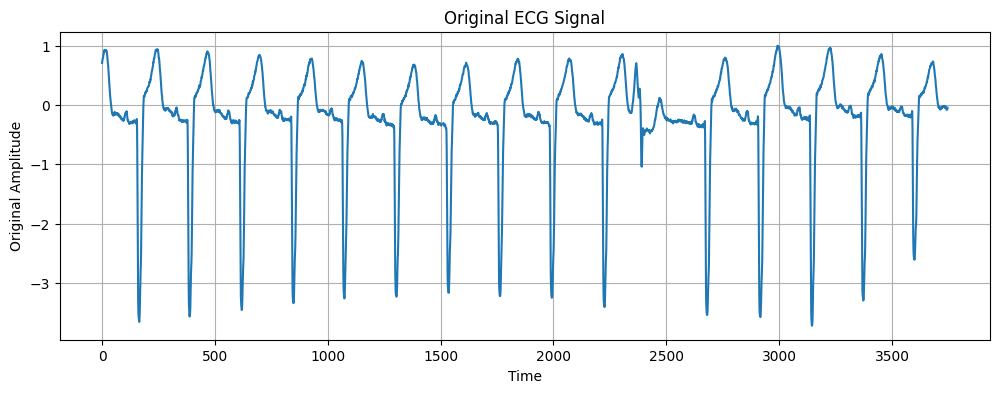

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(signal)
plt.title("Original ECG Signal")
plt.xlabel("Time")
plt.ylabel("Original Amplitude")
plt.grid(True)
plt.show()

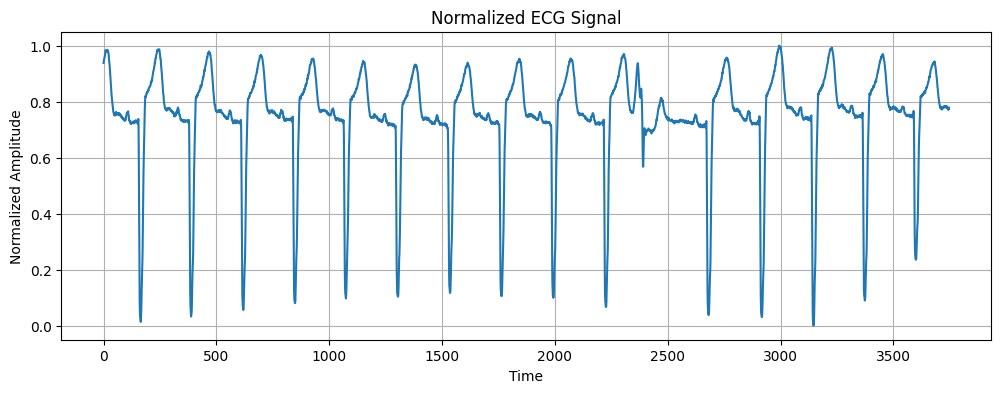

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(normalized_signal)
plt.title("Normalized ECG Signal")
plt.xlabel("Time")
plt.ylabel("Normalized Amplitude")
plt.grid(True)
plt.show()

### Create sequences

In [19]:
X, y = create_time_series(normalized_signal, time_steps)

### Reshape for LSTM input

In [20]:
X = X.reshape((X.shape[0], time_steps, 1))
y = y.reshape(-1, 1)

### Train-test split

In [21]:
split = int(train_ratio * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

### KMeans for RBF Centroids

In [22]:
X_flat = X.reshape(X.shape[0], -1)

In [23]:
kmeans = KMeans(n_clusters=hidden_size_ae, random_state=seed, n_init=10)

In [24]:
kmeans.fit(X_flat)

KMeans(n_clusters=16, n_init=10, random_state=13)

In [25]:
centers = kmeans.cluster_centers_

In [26]:
centers.shape

(16, 10)

In [27]:
total_input = hidden_size_ae + input_size_ae
padding = total_input - time_steps
padded_centers = np.hstack([np.zeros((hidden_size_ae, padding)), centers])

### Auto Encoder

#### Create model

In [28]:
# del ae_model

In [33]:
train_losses_ae = []
test_losses_ae = []

best_train_loss_ae = float("inf")
best_test_loss_ae = float("inf")
best_epoch_ae = float("inf")

In [34]:
encoderCell = LSTMCellRBF(
    input_size   = input_size_ae,
    hidden_size  = hidden_size_ae,
    init_centers = padded_centers
)

ae_model = AutoEncoder(
    encoder = encoderCell,
    hidden_dim = hidden_size_ae,
    output_dim_ae = 1
)

#### Train model

In [35]:
for epoch in range(epochs_ae):
    total_train_loss = 0
    total_test_loss = 0

    # --- Training ---
    for i in range(len(X_train)):
        x_seq = X_train[i]
        target = X_train[i][-1]

        loss = ae_model.backward(x_seq, target, learning_rate_ae)
        total_train_loss += loss

    # --- Testing ---
    for i in range(len(X_test)):
        x_seq = X_test[i]
        target = X_test[i][-1]

        reconstructed, _ = ae_model.forward(x_seq)
        loss = np.mean((reconstructed - target) ** 2)
        total_test_loss += loss

    avg_train_loss_ae = total_train_loss / len(X_train)
    avg_test_loss_ae = total_test_loss / len(X_test)
    train_losses_ae.append(avg_train_loss_ae)
    test_losses_ae.append(avg_test_loss_ae)

    if avg_test_loss_ae < best_test_loss_ae:
        best_train_loss_ae = avg_train_loss_ae
        best_test_loss_ae = avg_test_loss_ae
        best_epoch_ae = epoch
        ae_model.save_best_encoder()

    # print(f"Epoch {epoch+1}/{epochs_ae} | Train MSE = {avg_train_loss_ae:.6f} | Test MSE = {avg_test_loss_ae:.6f}")
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs_ae} | Train MSE = {avg_train_loss_ae:.6f} | Test MSE = {avg_test_loss_ae:.6f}")
print(f"\nAE Training is Done over {epochs_ae} epochs.\nBest Train MSE: {best_train_loss_ae:.6f} | Best Test MSE: {best_test_loss_ae:.6f} @ epoch: {best_epoch_ae+1}/{epochs_ae}.")

Epoch 0/200 | Train MSE = 0.013977 | Test MSE = 0.010020
Epoch 10/200 | Train MSE = 0.005261 | Test MSE = 0.005083
Epoch 20/200 | Train MSE = 0.003556 | Test MSE = 0.003666
Epoch 30/200 | Train MSE = 0.002725 | Test MSE = 0.002912
Epoch 40/200 | Train MSE = 0.002174 | Test MSE = 0.002392
Epoch 50/200 | Train MSE = 0.001760 | Test MSE = 0.001996
Epoch 60/200 | Train MSE = 0.001451 | Test MSE = 0.001702
Epoch 70/200 | Train MSE = 0.001227 | Test MSE = 0.001491
Epoch 80/200 | Train MSE = 0.001066 | Test MSE = 0.001339
Epoch 90/200 | Train MSE = 0.000950 | Test MSE = 0.001228
Epoch 100/200 | Train MSE = 0.000865 | Test MSE = 0.001143
Epoch 110/200 | Train MSE = 0.000801 | Test MSE = 0.001077
Epoch 120/200 | Train MSE = 0.000751 | Test MSE = 0.001025
Epoch 130/200 | Train MSE = 0.000713 | Test MSE = 0.000982
Epoch 140/200 | Train MSE = 0.000682 | Test MSE = 0.000947
Epoch 150/200 | Train MSE = 0.000656 | Test MSE = 0.000918
Epoch 160/200 | Train MSE = 0.000635 | Test MSE = 0.000893
Epoch 17

#### Result

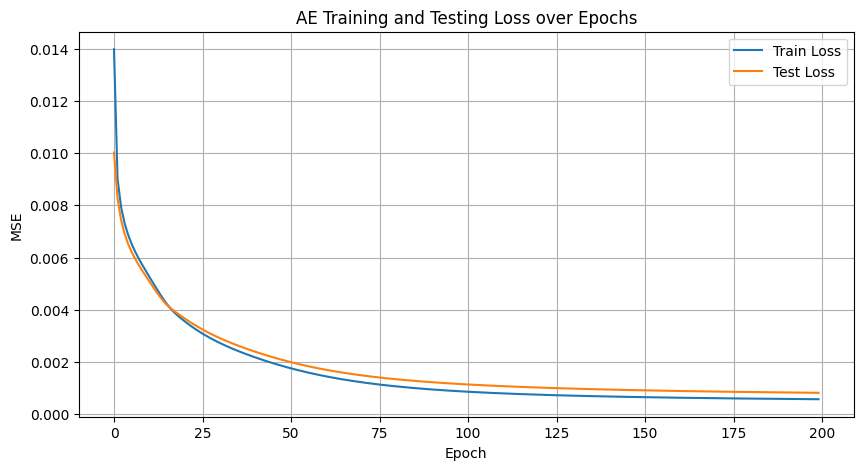

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_ae, label='Train Loss')
plt.plot(test_losses_ae, label='Test Loss')
plt.title("AE Training and Testing Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

### MLP

#### Create model

In [37]:
# del mlp_model

In [38]:
train_losses_mlp = []
test_losses_mlp = []

best_train_loss_mlp = float("inf")
best_test_loss_mlp = float("inf")
best_epoch_mlp = float("inf")

In [39]:
mlp_model = MLP(
    input_dim=mlp_input_dim,
    hidden_dims=mlp_hidden_dims,
    output_dim=mlp_output_dim
)

#### Train model

In [40]:
for epoch in range(epochs_mlp):
    total_train_loss_mlp = 0

    for i in range(len(X_train)):
        x_seq = X_train[i]
        y_true = y_train[i]

        encoded = encoderCell.forward(x_seq)
        y_pred = mlp_model.forward(encoded)
        loss = np.mean((y_pred - y_true) ** 2)
        total_train_loss_mlp += loss

        # Backward through MLP
        mlp_model.backward(y_true, learning_rate_mlp)

    avg_train_loss_mlp = total_train_loss_mlp / len(X_train)

    # ارزیابی روی تست
    total_test_loss_mlp = 0
    for i in range(len(X_test)):
        encoded = encoderCell.forward(X_test[i])
        y_pred = mlp_model.forward(encoded)
        loss = np.mean((y_pred - y_test[i]) ** 2)
        total_test_loss_mlp += loss

    avg_test_loss_mlp = total_test_loss_mlp / len(X_test)
    train_losses_mlp.append(avg_train_loss_mlp)
    test_losses_mlp.append(avg_test_loss_mlp)

    if avg_test_loss_mlp < best_test_loss_mlp:
        best_train_loss_mlp = avg_train_loss_mlp
        best_test_loss_mlp = avg_test_loss_mlp
        best_epoch_mlp = epoch
        mlp_model.save_best()

    # print(f"Epoch {epoch+1}/{epochs_mlp} | Train MSE = {avg_train_loss_mlp:.6f} | Test MSE = {avg_test_loss_mlp:.6f}")
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs_mlp} | Train MSE = {avg_train_loss_mlp:.6f} | Test MSE = {avg_test_loss_mlp:.6f}")

print(f"\nMLP Training is Done over {epochs_mlp} epochs.\nBest Train MSE: {best_train_loss_mlp:.6f} | Best Test MSE: {best_test_loss_mlp:.6f} @ epoch: {best_epoch_mlp+1}/{epochs_mlp}.")

Epoch 0/250 | Train MSE = 0.008027 | Test MSE = 0.003798
Epoch 10/250 | Train MSE = 0.000856 | Test MSE = 0.002588
Epoch 20/250 | Train MSE = 0.000596 | Test MSE = 0.001498
Epoch 30/250 | Train MSE = 0.000497 | Test MSE = 0.000901
Epoch 40/250 | Train MSE = 0.000447 | Test MSE = 0.000676
Epoch 50/250 | Train MSE = 0.000416 | Test MSE = 0.000580
Epoch 60/250 | Train MSE = 0.000394 | Test MSE = 0.000531
Epoch 70/250 | Train MSE = 0.000375 | Test MSE = 0.000502
Epoch 80/250 | Train MSE = 0.000357 | Test MSE = 0.000482
Epoch 90/250 | Train MSE = 0.000341 | Test MSE = 0.000466
Epoch 100/250 | Train MSE = 0.000325 | Test MSE = 0.000452
Epoch 110/250 | Train MSE = 0.000309 | Test MSE = 0.000439
Epoch 120/250 | Train MSE = 0.000294 | Test MSE = 0.000427
Epoch 130/250 | Train MSE = 0.000280 | Test MSE = 0.000416
Epoch 140/250 | Train MSE = 0.000266 | Test MSE = 0.000406
Epoch 150/250 | Train MSE = 0.000253 | Test MSE = 0.000398
Epoch 160/250 | Train MSE = 0.000241 | Test MSE = 0.000392
Epoch 17

#### Result

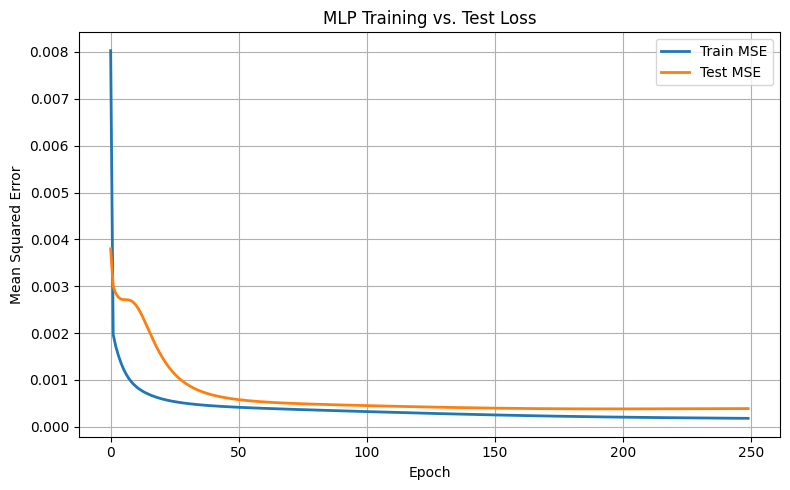

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses_mlp, label="Train MSE", linewidth=2)
plt.plot(test_losses_mlp, label="Test MSE", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("MLP Training vs. Test Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Overal Model Evaluation

In [42]:
y_pred_test = []

In [43]:
for i in range(len(X_test)):
    encoded = ae_model.encoder.forward(X_test[i])
    y_pred = mlp_model.forward(encoded)
    y_pred_test.append(y_pred)

In [44]:
y_pred_test = np.array(y_pred_test).reshape(-1)
y_true_test = y_test.reshape(-1)

In [45]:
mse_test = np.mean((y_pred_test - y_true_test)**2)
mae_test = np.mean(np.abs(y_pred_test - y_true_test))

In [46]:
print(f"\n🔹 Normalized Test MSE: {mse_test:.6f}")
print(f"🔹 Normalized Test MAE: {mae_test:.6f}\n")


🔹 Normalized Test MSE: 0.000389
🔹 Normalized Test MAE: 0.014880



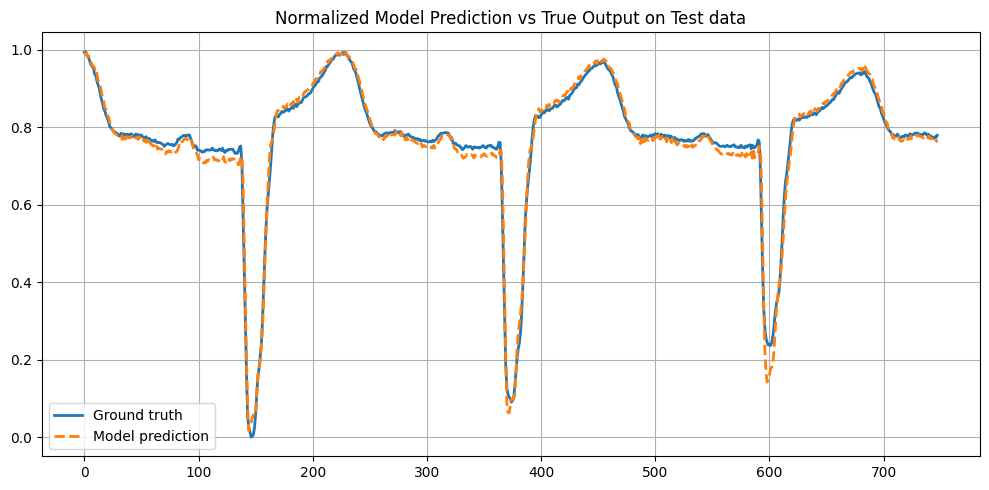

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(y_true_test, label="Ground truth", linewidth=2)
plt.plot(y_pred_test, label="Model prediction", linestyle="--", linewidth=2)
plt.title("Normalized Model Prediction vs True Output on Test data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
min_signal = np.min(signal)
max_signal = np.max(signal)

In [49]:
y_pred_test_denorm = denormalize_data(y_pred_test, min_signal, max_signal)
y_true_test_denorm = denormalize_data(y_true_test, min_signal, max_signal)

In [50]:
mse_denorm = np.mean((y_pred_test_denorm - y_true_test_denorm) ** 2)
mae_denorm = np.mean(np.abs(y_pred_test_denorm - y_true_test_denorm))

In [51]:
print(f"\n✅ Denormalized Test MSE: {mse_denorm:.6f}")
print(f"✅ Denormalized Test MAE: {mae_denorm:.6f}\n")


✅ Denormalized Test MSE: 0.008670
✅ Denormalized Test MAE: 0.070232



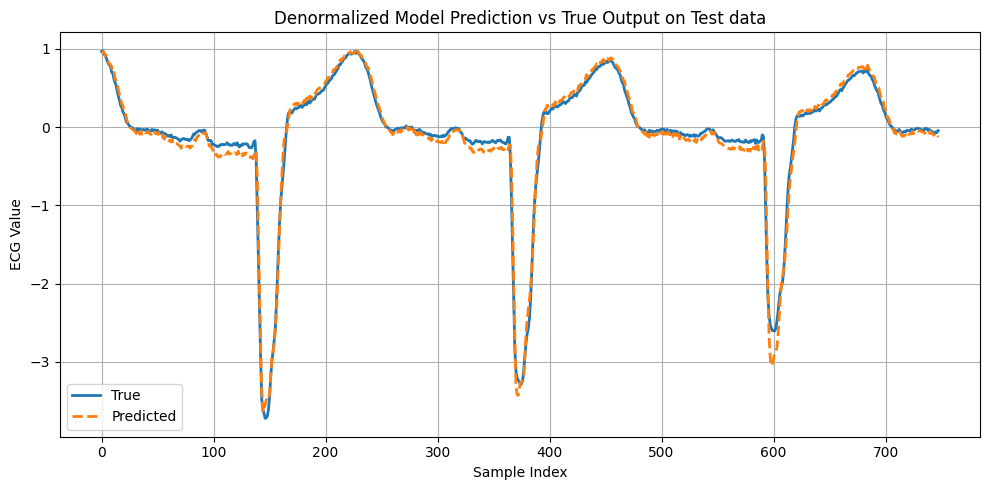

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(y_true_test_denorm, label="True", linewidth=2)
plt.plot(y_pred_test_denorm, label="Predicted", linestyle="--", linewidth=2)
plt.title("Denormalized Model Prediction vs True Output on Test data")
plt.xlabel("Sample Index")
plt.ylabel("ECG Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Save Best Model

In [53]:
best_weights = {
    "mlp_layers": [w.copy() for w in mlp_model.best_weights["layers"]],
    "mlp_biases": [b.copy() for b in mlp_model.best_weights["biases"]],
    "encoder_weights": {k: v.copy() for k, v in ae_model.best_encoder_weights.items()}
}

In [54]:
if save_best_model_weights:
    with open(full_model_file, "wb") as f:
        pickle.dump(best_weights, f)
    print(f"✅ Full model (Encoder + MLP) weights saved to '{full_model_file}'")

✅ Full model (Encoder + MLP) weights saved to 'best_model_weights.pkl'
